# Variational Autoencoder


In [1]:
#https://www.tensorflow.org/tutorials/generative/cvae

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Input, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset

import os
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle


2023-05-26 09:31:52.953994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 09:31:53.186826: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 09:31:53.226803: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-05-26 09:31:53.226823: I tensorflow/compiler/xla/stream

# Aux functions for display purposes

In [2]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input)
    fig = plt.figure(figsize=(16,256))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 16, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    
    
def plot_scatter(x,y,train_Y):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 'darkgreen', 'yellow', 'brown', 'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(12,10))
    ax = fig.gca()
    ax.set_aspect('equal')
    plt.scatter(x, y, c = train_Y, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()
    plt.gca().add_patch(Rectangle((-2,-2), 4,4, linewidth=2, edgecolor='r', facecolor='none'))   
    plt.show()
    
    
# assumes len samples is a perfect square
def show_samples(samples):
    
    k = int(math.sqrt(len(samples)))
    fig = plt.figure(figsize=(k,k))
    
    for i in range(len(samples)):
        plt.subplot(k, k, i+1)
        plt.imshow(np.asarray(samples)[i, :, :, 0], cmap='gray')
        plt.axis('off')    


# Config data

In [3]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1

BATCH_SIZE = 32
LATENT_DIM = 2

models_path = '/vae'

train_online = True

In [36]:
(train_X,train_Y), (test_X, test_Y) = mnist.load_data()

print(train_X.shape)

train_X = train_X.reshape(train_X.shape[0], 28,28,1).astype('float32') / 255.0

print(train_X.shape)

test_X = test_X.reshape(test_X.shape[0], 28,28,1).astype('float32') / 255.0

TEST_BUF = len(test_X)
TRAIN_BUF = len(train_X)
NUM_CLASSES = int(np.max(train_Y) + 1)

train_Y = tf.keras.utils.to_categorical(train_Y, NUM_CLASSES)
test_Y = tf.keras.utils.to_categorical(test_Y, NUM_CLASSES)

train_dataset = Dataset.from_tensor_slices((train_X, train_Y))
train_dataset = train_dataset.shuffle(TRAIN_BUF).batch(BATCH_SIZE)

test_dataset = Dataset.from_tensor_slices((test_X, test_Y)).batch(BATCH_SIZE)

(60000, 28, 28)
(60000, 28, 28, 1)


In [16]:
class SamplingLayer(layers.Layer):
    
    @tf.function
    def call(self, inputs):
        z_mean, z_logvar = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape = (batch,dim))
        return z_mean + tf.exp(0.5 * z_logvar) * epsilon
    

In [10]:
inputs = Input(shape=(WIDTH, HEIGHT, NUM_CHANNELS))

encoder = Conv2D(32, (3,3), strides=2, padding='same')(inputs)
encoder = LeakyReLU(alpha=0.2)(encoder)
encoder = BatchNormalization()(encoder)

encoder = Conv2D(64, (3,3), strides=2, padding='same')(encoder)
encoder = LeakyReLU(alpha=0.2)(encoder)
encoder = BatchNormalization()(encoder)

volumeSize = encoder.shape
encoder = Flatten()(encoder)

z_mean = Dense(LATENT_DIM)(encoder)
z_logvar = Dense(LATENT_DIM)(encoder)

z_layer = SamplingLayer()([z_mean,z_logvar])

encoder = Model(inputs, [z_layer,z_mean,z_logvar])

tf.keras.utils.plot_model(encoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
print(volumeSize)

(None, 7, 7, 64)


In [37]:
z_input = Input(shape=(LATENT_DIM,))
class_input = Input(shape=(NUM_CLASSES))

decoder_input = tf.keras.layers.concatenate(inputs=[z_input, class_input])

decoder = Dense(np.prod(volumeSize[1:]))(decoder_input)
decoder = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), strides=2, padding='same')(decoder)
decoder = LeakyReLU(alpha=0.2)(decoder)
decoder = BatchNormalization()(decoder)

decoder = Conv2DTranspose(32, (3,3), strides=2, padding='same')(decoder)
decoder = LeakyReLU(alpha=0.2)(decoder)
decoder = BatchNormalization()(decoder)

decoder = Conv2DTranspose(NUM_CHANNELS, (3,3), padding='same')(decoder)
output = Activation('sigmoid')(decoder)

decoder = Model([z_input, class_input], output)
decoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 12)           0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 3136)         40768       ['concatenate[0][0]']      

In [39]:
vae = Model([inputs, class_input], decoder((z_layer, class_input)))

tf.keras.utils.plot_model(vae, show_shapes=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


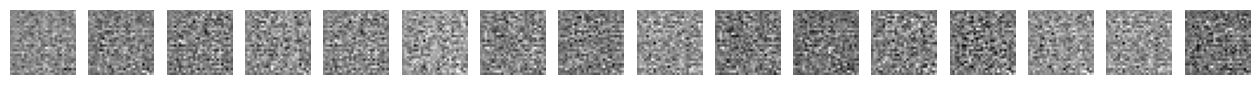

In [40]:
num_examples_to_generate = 16
random_latent_vector = tf.random.normal(shape=[num_examples_to_generate,LATENT_DIM])

random_labels = tf.random.uniform([num_examples_to_generate, 1], 0,9, dtype=tf.dtypes.int32)
random_labels = tf.keras.utils.to_categorical(random_labels, NUM_CLASSES)

generate_and_save_images(decoder, 0, [random_latent_vector, random_labels])

1: 36.37259292602539 2.9467132091522217 33.42588424682617
2: 32.63341522216797 3.396113634109497 29.2373046875
3: 32.21891403198242 3.431428909301758 28.78753089904785
4: 31.987091064453125 3.456641435623169 28.53050422668457
5: 31.80513572692871 3.4582326412200928 28.346885681152344


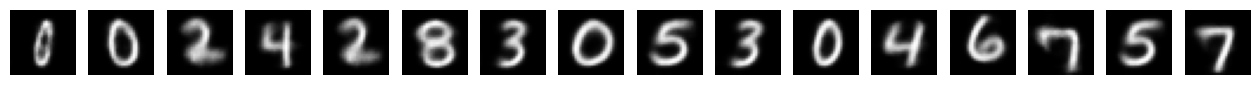

6: 31.6866455078125 3.4712212085723877 28.215391159057617
7: 31.592533111572266 3.4819557666778564 28.110559463500977
8: 31.50932502746582 3.492659568786621 28.016647338867188
9: 31.426437377929688 3.486678123474121 27.93982696533203
10: 31.380077362060547 3.504021406173706 27.876081466674805


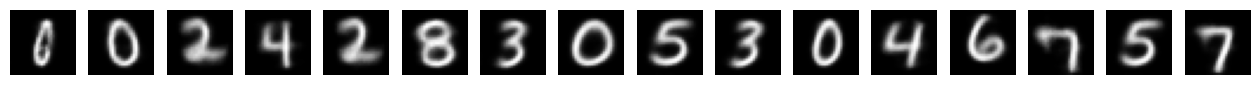

11: 31.329790115356445 3.5106074810028076 27.81917953491211
12: 31.277822494506836 3.4976625442504883 27.780181884765625
13: 31.232559204101562 3.5015857219696045 27.731002807617188
14: 31.21036720275879 3.5166068077087402 27.69378089904785
15: 31.15904998779297 3.5069851875305176 27.652009963989258


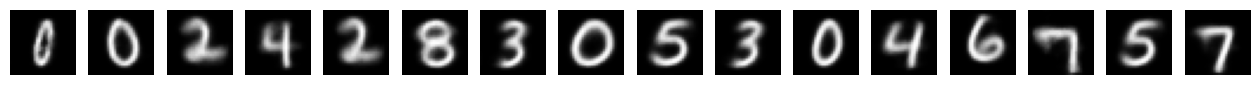

16: 31.130571365356445 3.51233172416687 27.61823272705078
17: 31.11158561706543 3.5128111839294434 27.598777770996094
18: 31.088932037353516 3.5092086791992188 27.57968521118164
19: 31.058349609375 3.5145318508148193 27.54384422302246
20: 31.03770637512207 3.5157995223999023 27.521875381469727


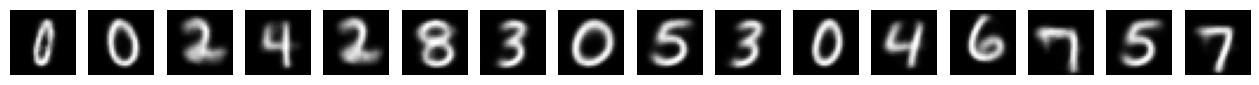

21: 31.016952514648438 3.51845383644104 27.498504638671875
22: 30.99015998840332 3.5136022567749023 27.476511001586914
23: 30.980762481689453 3.519456148147583 27.461301803588867
24: 30.973642349243164 3.524029016494751 27.449575424194336
25: 30.956911087036133 3.524698495864868 27.432231903076172


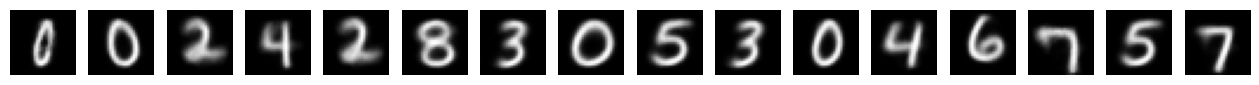

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

EPOCHS = 25

@tf.function
def train_step(encoder, decoder, train_x, train_y, optimizer):
    
    with tf.GradientTape() as tape:
        z, z_mean, z_logvar = encoder(train_x)
        x = decoder([z,train_y])
        
        kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        recon_loss = tf.reduce_sum(tf.keras.losses.mse(train_x,x), axis=(1,2))
        recon_loss = tf.reduce_mean(recon_loss)
        
        loss = kl_loss + recon_loss
        
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    
    return loss, kl_loss, recon_loss

if train_online:
    
    for epoch in range(1, EPOCHS+1):
        
        epoch_loss = 0
        rec_loss = 0
        kls_loss = 0
        batch = 0
        
        for train_x,train_y in train_dataset:
            
            loss, kl_loss, recon_loss = train_step(encoder, decoder, train_x, train_y, optimizer)
            
            epoch_loss += tf.reduce_mean(loss)
            rec_loss += tf.reduce_mean(recon_loss)
            kls_loss += tf.reduce_mean(kl_loss)
            batch += 1
            
        print(f'{epoch}: {epoch_loss/batch} {kls_loss/batch} {rec_loss/batch}')
        if epoch % 5 == 0:
            generate_and_save_images(decoder, epoch, [random_latent_vector, random_labels])

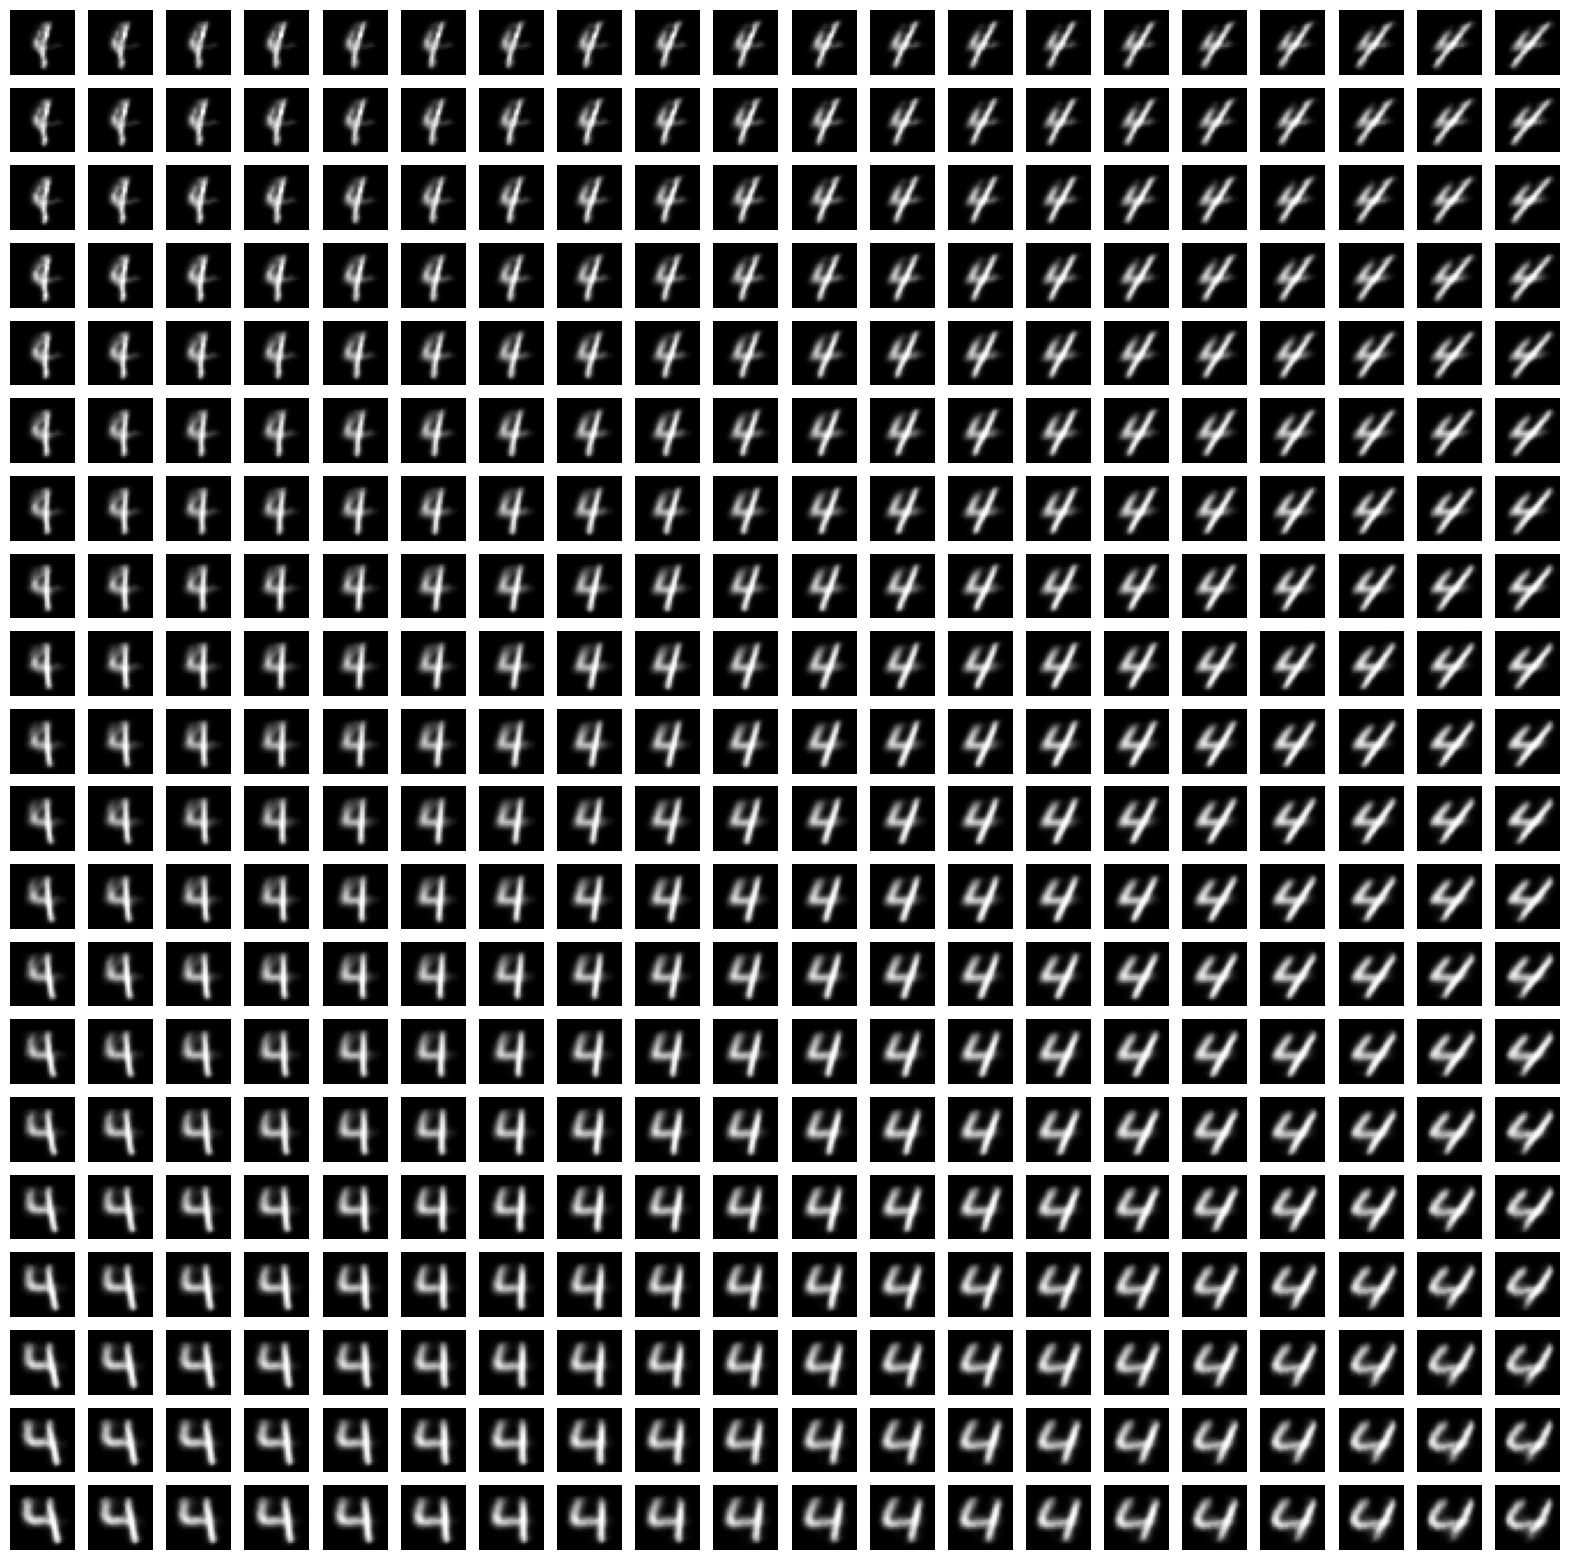

In [43]:
vector_generation = []
a = [[0,0,0,0,1,0,0,0,0,0]] * 400
for i in range(20):
    for j in range(20):
        vector_generation.append([-2.0 + i * 0.2, -2.0 + j * 0.2])
        
predictions = decoder([np.asarray(vector_generation), np.asarray(a)])
show_samples(predictions)

In [32]:
encoded = encoder.predict(train_x)

1/1 [==============================] - 0s 13ms/step


ValueError: 'c' argument has 60000 elements, which is inconsistent with 'x' and 'y' with size 32.

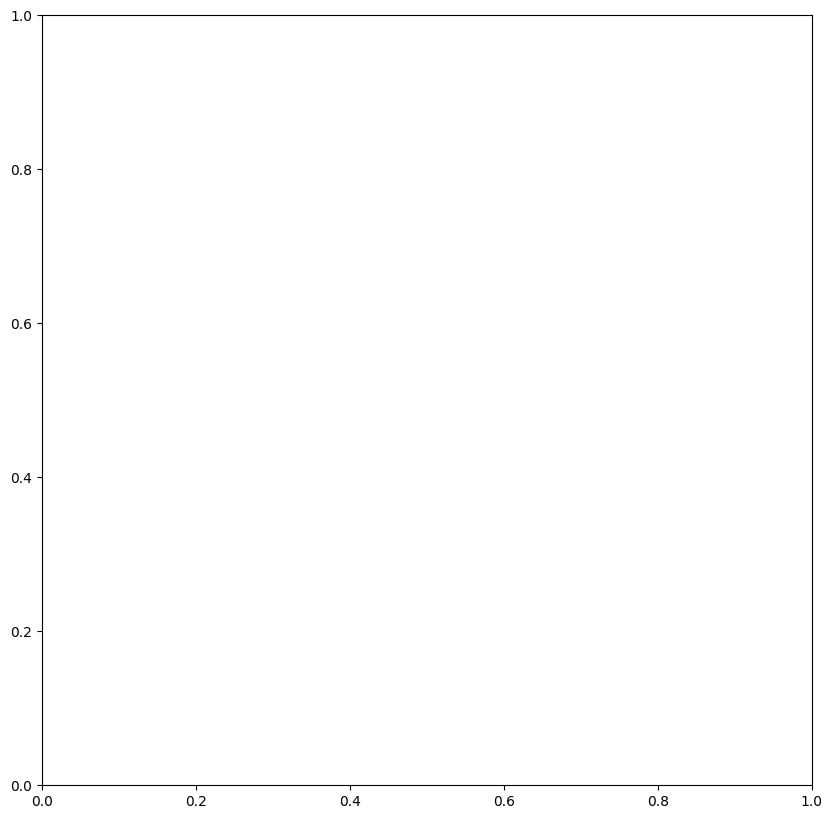

In [35]:
x = np.array(encoded[1])[:,0]
y = np.array(encoded[1])[:,1]

plot_scatter(x,-y, train_Y)